# **How to plot data on maps**

In [1]:
import string
import time
import argparse as ap
import sys
import os
import obspy
import numpy as np
import obspy.core as oc
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['pdf.fonttype'] = 42
from datetime import datetime, timedelta
from obspy.imaging.beachball import beachball, beach, mt2plane, tdl, mt2axes, MomentTensor
from matplotlib.patches import Polygon
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

import pylab as plt
import pandas as pd
import h5py


from obspy import read_inventory


In [2]:
# generate the fault plane solutions from the moment tensor component
# it is needed by pandas
def MT2plane1(row):
    mt_values = [row['m_rr'], row['m_tt'], row['m_pp'], row['m_rt'], row['m_rp'], row['m_tp']]
    mt_values_MT = MomentTensor(mt_values,26)
    plane = mt2plane(mt_values_MT)
    return plane.strike, plane.dip, plane.rake

In [3]:
def shoot(lon, lat, azimuth, maxdist=None):
    """Shooter Function
    Original javascript on http://williams.best.vwh.net/gccalc.htm
    Translated to python by Thomas Lecocq
    """
    glat1 = lat * np.pi / 180.
    glon1 = lon * np.pi / 180.
    s = maxdist / 1.852
    faz = azimuth * np.pi / 180.

    EPS= 0.00000000005
    if ((np.abs(np.cos(glat1))<EPS) and not (np.abs(np.sin(faz))<EPS)):
        alert("Only N-S courses are meaningful, starting at a pole!")

    a=6378.13/1.852
    f=1/298.257223563
    r = 1 - f
    tu = r * np.tan(glat1)
    sf = np.sin(faz)
    cf = np.cos(faz)
    if (cf==0):
        b=0.
    else:
        b=2. * np.arctan2 (tu, cf)

    cu = 1. / np.sqrt(1 + tu * tu)
    su = tu * cu
    sa = cu * sf
    c2a = 1 - sa * sa
    x = 1. + np.sqrt(1. + c2a * (1. / (r * r) - 1.))
    x = (x - 2.) / x
    c = 1. - x
    c = (x * x / 4. + 1.) / c
    d = (0.375 * x * x - 1.) * x
    tu = s / (r * a * c)
    y = tu
    c = y + 1
    while (np.abs (y - c) > EPS):

        sy = np.sin(y)
        cy = np.cos(y)
        cz = np.cos(b + y)
        e = 2. * cz * cz - 1.
        c = y
        x = e * cy
        y = e + e - 1.
        y = (((sy * sy * 4. - 3.) * y * cz * d / 6. + x) *
              d / 4. - cz) * sy * d + tu

    b = cu * cy * cf - su * sy
    c = r * np.sqrt(sa * sa + b * b)
    d = su * cy + cu * sy * cf
    glat2 = (np.arctan2(d, c) + np.pi) % (2*np.pi) - np.pi
    c = cu * cy - su * sy * cf
    x = np.arctan2(sy * sf, c)
    c = ((-3. * c2a + 4.) * f + 4.) * c2a * f / 16.
    d = ((e * cy * c + cz) * sy * c + y) * sa
    glon2 = ((glon1 + x - (1. - c) * d * f + np.pi) % (2*np.pi)) - np.pi	

    baz = (np.arctan2(sa, b) + np.pi) % (2 * np.pi)

    glon2 *= 180./np.pi
    glat2 *= 180./np.pi
    baz *= 180./np.pi

    return (glon2, glat2, baz)

def equi(m, centerlon, centerlat, radius, *args, **kwargs):
    glon1 = centerlon
    glat1 = centerlat
    X = []
    Y = []
    for azimuth in range(0, 360):
        glon2, glat2, baz = shoot(glon1, glat1, azimuth, radius)
        X.append(glon2)
        Y.append(glat2)
    X.append(X[0])
    Y.append(Y[0])

    #~ m.plot(X,Y,**kwargs) #Should work, but doesn't...
    X,Y = m(X,Y)
    plt.plot(X,Y,**kwargs)



### Read Instance metadata

In [4]:
METADIR = '../metadata'
HDFDIR = '../data'
FIGDIR='../samples'

# data
events_metaname=os.path.join(METADIR,'metadata_Events_10k.csv') # Either Counts and GroundMotion
events_hdfname=os.path.join(HDFDIR,'Instance_Evs_Counts10k.hdf5')


In [5]:
events_metaData = pd.read_csv(events_metaname, keep_default_na=False, dtype={'station_location_code': object, 
           'source_mt_eval_mode':object,'source_mt_status': object,'source_mechanism_strike_dip_rake': object, 
           'source_mechanism_moment_tensor': object, 'trace_p_arrival_time': object, 'trace_s_arrival_time': object})

/home/jovyan/jhshare/INSTANCE/envs/instance/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (21,57,58,59,60,61,62,70,71,75,76,77,78,79,80,83,84,85,86,87,88,91,92,93,94,95,96,99,100,101,102,103,104,106) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Generate hypocenter map (Figure 1a)

In [8]:
# generate first the stations
df_eq0 = events_metaData[['source_id', 'source_origin_time', 'source_latitude_deg',
       'source_longitude_deg','source_depth_km', 'source_magnitude']].groupby('source_id').mean()
# count using sta_lat as dummy index
df_eq1 = events_metaData[['source_id', 'source_magnitude']].groupby('source_id').count()
# rename
df_eq1.rename(columns={'source_magnitude': "counts"},inplace=True)

# generate the dataframe
df_eq = pd.concat([df_eq0,df_eq1], axis=1)

In [9]:
# Define symbol dimension as a funcion of source magnitude
mag_size = []
f = 2.0
for m in df_eq.source_magnitude.values:
    if m <= 1.0: fact  = f*1.
    if m > 1.0 and m <= 2.0: fact  = f*4
    if m > 2.0 and m <= 3.0: fact  = f*8
    if m > 3.0 and m <= 4.0: fact  = f*16
    if m > 4.0 and m <= 5.0: fact  = f*32
    if m > 5.0 and m <= 6.0: fact  = f*64
    if m > 6.0 and m <= 7.0: fact  = f*128
    if m > 7.0: fact  = f*150
    mag_size.append(fact)

In [10]:
# Define symbol color as a function of hypocenter depth 

indexList = df_eq['source_depth_km'].tolist()
minIndex = min(indexList)
maxIndex = max(indexList)

# Figure out colors for each index
norm = Normalize(vmin=minIndex, vmax=maxIndex, clip=False)
mapper=ScalarMappable(norm=norm, cmap='gist_rainbow')

http://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/MapServer/export?bbox=1134875.118085531,3880421.5902590444,2394467.101892613,5386501.153849247&bboxSR=3003&imageSR=3003&size=500,597&dpi=96&format=png32&transparent=true&f=image


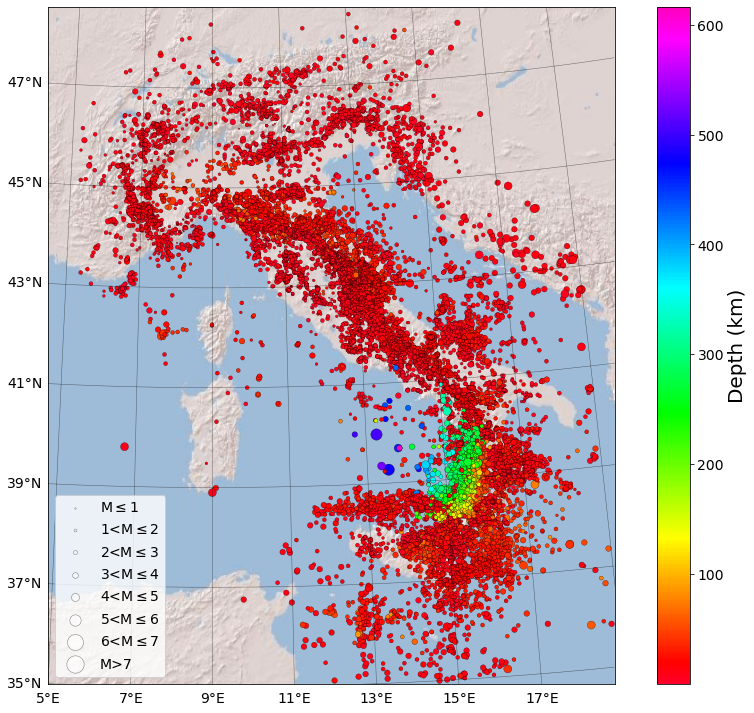

In [11]:
fig = plt.figure(figsize=(12,10))

#Custom adjust of the subplots

plt.subplots_adjust(left=0.05,right=0.95,top=0.90,bottom=0.05,wspace=0.15,hspace=0.05)

ax = plt.subplot(111)
italonmin=5.00
italonmax=21.
italatmin=35.00
italatmax=48.00



#Let's create a basemap of the world
ita=[italonmin,italatmin,italonmax,italatmax]

# m = Basemap(resolution='l',projection='robin',lon_0=0)
m = Basemap(llcrnrlon=ita[0],llcrnrlat=ita[1],urcrnrlon=ita[2],urcrnrlat=ita[3], epsg=3003)
m.arcgisimage(service='World_Shaded_Relief', xpixels = 500, verbose= True)

m.drawparallels(np.arange(italatmin,italatmax,2.),linewidth=0.5,labels=[1,0,0,0],fontsize=14)
m.drawmeridians(np.arange(italonmin,italonmax,2.),linewidth=0.5,labels=[0,0,0,1],fontsize=14)

rsnlat = df_eq['source_latitude_deg'].tolist()
rsnlon = df_eq['source_longitude_deg'].tolist()

cc = df_eq['source_depth_km'].tolist()
sx,sy = m(rsnlon,rsnlat)
m.scatter(sx, sy, mag_size, c=cc, cmap='gist_rainbow',marker="o",edgecolor='black', linewidths=0.25, zorder=2)


# for i in range(len(rsncode)):
#     plt.text(sx[i], sy[i]+up, rsncode[i], ha="center", va="bottom", family="monospace", 
#              weight="bold",fontsize=fontsize, zorder=5,clip_on=True)

p1 = plt.scatter([], [], 2, c = 'w',  marker= "o",edgecolors='k', linewidths=0.5,alpha=0.5)
p2 = plt.scatter([], [], 8, c = 'w',  marker="o",edgecolors='k', linewidths=0.5,alpha=0.5)
p3 = plt.scatter([], [], 16, c = 'w', marker="o",edgecolors='k', linewidths=0.5,alpha=0.5)
p4 = plt.scatter([], [], 32, c = 'w', marker="o",edgecolors='k', linewidths=0.5,alpha=0.5)
p5 = plt.scatter([], [], 64, c = 'w', marker="o",edgecolors='k', linewidths=0.5,alpha=0.5)
p6 = plt.scatter([], [], 128, c = 'w', marker="o",edgecolors='k', linewidths=0.5,alpha=0.5)
p7 = plt.scatter([], [], 256, c = 'w', marker="o",edgecolors='k', linewidths=0.5,alpha=0.5)
p8 = plt.scatter([], [], 300, facecolor='w', marker="o",edgecolors='k', linewidths=0.5,alpha=0.5)

plt.legend([p1,p2,p3,p4,p5,p6,p7,p8],["M$\leq$1","1<M$\leq$2","2<M$\leq$3","3<M$\leq$4","4<M$\leq$5","5<M$\leq$6","6<M$\leq$7","M>7",],
           labelspacing=0.6, loc='lower left', fontsize=14)



fig = plt.gcf()
mapper.set_array(cc)
cbar=fig.colorbar(mapper)
cbar.set_label('Depth (km)',fontsize=20)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(14)

plt.tight_layout()
figname=os.path.join(FIGDIR,'Ita_epicenter.png')
plt.savefig(figname,dpi=300)
plt.show()

## Generate Station Map (Figure 1b)

In [12]:
# generate first the stations
df_sta0 = events_metaData[['station_code','station_latitude_deg','station_longitude_deg']].groupby('station_code').mean()
# count using sta_lat as dummy index
df_sta1 = events_metaData[['station_code', 'station_latitude_deg']].groupby('station_code').count()
# rename
df_sta1.rename(columns={"station_latitude_deg": "counts"},inplace=True)

# generate the dataframe
df_sta = pd.concat([df_sta0,df_sta1], axis=1)

In [13]:
# Define symbol dimension as a funcion of number of picks recorded at each seismic station
mark_size = []
for m in df_sta.counts.values:
    if m <= 100: fact  = 10.
    if m > 100 and m <= 500: fact  = 20
    if m > 500 and m <= 1000: fact  = 40
    if m > 1000 and m <= 5000: fact  = 80
    if m > 5000: fact  = 160
    mark_size.append(int(fact))

http://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/MapServer/export?bbox=1134875.118085531,3880421.5902590444,2394467.101892613,5386501.153849247&bboxSR=3003&imageSR=3003&size=500,597&dpi=96&format=png32&transparent=true&f=image


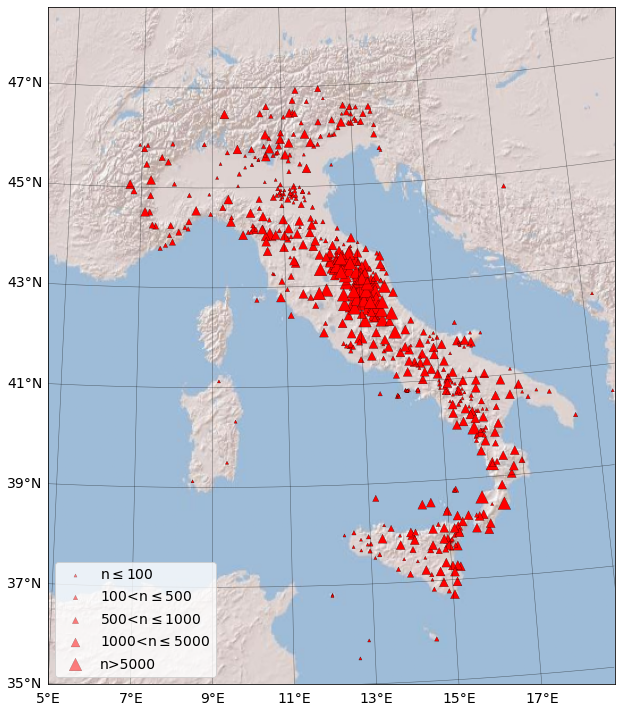

In [14]:
fig = plt.figure(figsize=(12,10))

#Custom adjust of the subplots

plt.subplots_adjust(left=0.05,right=0.95,top=0.90,bottom=0.05,wspace=0.15,hspace=0.05)

ax = plt.subplot(111)
italonmin=5.00
italonmax=21.
italatmin=35.00
italatmax=48.00


#Let's create a basemap of the world
ita=[italonmin,italatmin,italonmax,italatmax]

# m = Basemap(resolution='l',projection='robin',lon_0=0)
m = Basemap(llcrnrlon=ita[0],llcrnrlat=ita[1],urcrnrlon=ita[2],urcrnrlat=ita[3], epsg=3003)
m.arcgisimage(service='World_Shaded_Relief', xpixels = 500, verbose= True)

m.drawparallels(np.arange(italatmin,italatmax,2.),linewidth=0.5,labels=[1,0,0,0],fontsize=14)
m.drawmeridians(np.arange(italonmin,italonmax,2.),linewidth=0.5,labels=[0,0,0,1],fontsize=14)

rsnlat = df_sta['station_latitude_deg'].tolist()
rsnlon = df_sta['station_longitude_deg'].tolist()

sx,sy = m(rsnlon,rsnlat)
m.scatter(sx, sy, mark_size, color="r", marker="^",edgecolor='black',linewidths=0.25, zorder=2)


# for i in range(len(rsncode)):
#     plt.text(sx[i], sy[i]+up, rsncode[i], ha="center", va="bottom", family="monospace", 
#              weight="bold",fontsize=fontsize, zorder=5,clip_on=True)

p1 = plt.scatter([], [], 10, c = 'r',  marker= "^",edgecolors='k', linewidths=0.25,alpha=0.5)
p2 = plt.scatter([], [], 20, c = 'r',  marker="^",edgecolors='k', linewidths=0.25,alpha=0.5)
p3 = plt.scatter([], [], 40, c = 'r', marker="^",edgecolors='k', linewidths=0.25,alpha=0.5)
p4 = plt.scatter([], [], 80, c = 'r', marker="^",edgecolors='k', linewidths=0.25,alpha=0.5)
p5 = plt.scatter([], [], 160, c = 'r', marker="^",edgecolors='k', linewidths=0.25,alpha=0.5)

plt.legend([p1,p2,p3,p4,p5],["n$\leq$100","100<n$\leq$500","500<n$\leq$1000","1000<n$\leq$5000","n>5000",],
           labelspacing=0.6, loc='lower left', fontsize=14)

plt.tight_layout()
figname=os.path.join(FIGDIR,'Ita_station.png')
plt.savefig(figname,dpi=300)
plt.show()

## Generate focal moment tensor map (Figure 2)

In [15]:
# Create a DataFrame with the events that have the moment tensor solution

df_eq0 = events_metaData[['source_id', 'source_latitude_deg','source_longitude_deg','source_depth_km', 'source_magnitude',
                   'source_mechanism_strike_dip_rake','source_mechanism_moment_tensor']]

df_eq0['source_mechanism_moment_tensor'] = df_eq0['source_mechanism_moment_tensor'].replace(r'^\s*$', np.nan, regex=True)

df_eq0 = df_eq0.dropna().groupby('source_id').first()

/home/jovyan/jhshare/INSTANCE/envs/instance/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
fig = plt.figure(figsize=(12,10))

## Symbol color is defined as a function of the rake of the computed fault planes solutions 
## Symbol size is defined as a function of the source_magnitude

plt.subplots_adjust(left=0.05,right=0.95,top=0.90,bottom=0.05,wspace=0.15,hspace=0.05)

ax = plt.subplot(111)
italonmin=5.00
italonmax=21.
italatmin=35.00
italatmax=48.00



#Let's create a basemap of the world
ita=[italonmin,italatmin,italonmax,italatmax]

# m = Basemap(resolution='l',projection='robin',lon_0=0)
m = Basemap(llcrnrlon=ita[0],llcrnrlat=ita[1],urcrnrlon=ita[2],urcrnrlat=ita[3], epsg=3003)
m.arcgisimage(service='World_Shaded_Relief', xpixels = 500, verbose= True)

m.drawparallels(np.arange(italatmin,italatmax,2.),linewidth=0.5,labels=[1,0,0,0],fontsize=14)
m.drawmeridians(np.arange(italonmin,italonmax,2.),linewidth=0.5,labels=[0,0,0,1],fontsize=14)


for i, row  in df_eq0.iterrows():

    stringa=row['source_mechanism_moment_tensor']
    row1 = {}
    campi = stringa.split('\n\t')
    for c in campi[1:]:
        comp, value = [x.strip() for x in c.split(':')]
        row1[comp] = eval(value)
    moment_list = [row1.get('m_rr'),row1.get('m_tt'),row1.get('m_pp'),
                   row1.get('m_rt'),row1.get('m_rp'),row1.get('m_tp')]
    strike_dip_planes = {}
    strike_dip_planes['SDR1'] = MT2plane1(row1)
    
    rsnlat = row['source_latitude_deg']
    rsnlon = row['source_longitude_deg']

    sx,sy = m(rsnlon,rsnlat)
    width = row['source_magnitude']*7.5e3
    strike_dip_planes = {}
    strike_dip_planes['SDR1'] = MT2plane1(row1)
    rake=strike_dip_planes['SDR1'][2]
    if rake > -45 and rake < 45:
        col='k'
    elif rake > 135 and rake < 225:
        col='k'
    elif rake >= 45 and rake <= 135:
        col='r'
    elif rake >= 225 and rake <= 315:
        col='b'

    ax = plt.gca()
    b = beach(moment_list, xy=(sx, sy), facecolor=col, width=width, linewidth=0.25, alpha=1)
    b.set_zorder(10)
    ax.add_collection(b)


fig = plt.gcf()

plt.tight_layout()
figname=os.path.join(FIGDIR,'Ita_focal.png')
plt.savefig(figname,dpi=300)
plt.show()